In [1]:
# import dbfread
# import pandas as pd
# import numpy as np
# dbf = dbfread.read('../input/Virginia_Crashes.dbf')
# print(dbf[1])
# df=pd.DataFrame(dbf)
# df.to_csv('rawdata.csv',index= False)

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('../input/rawdata.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,OBJECTID,CRASH_DOCU,CRASH_DATE,COLLISION_,CRASH_SEVE,CRASH_WEAT,VDOT_PROPE,WORK_ZONE,NO_OF_VEHI,LIGHT_COND,...,LOCATION_O,CRASH_HOUR,CRASH_YEAR,PHYSICAL_J,PHYSICAL_1,RTE_TYPE_C,RTE_TYPE_N,VDOT_DISTR,VDOT_DIS_1,RTE_COMMON
0,1001,101270316,2010-03-03T00:00:00.000Z,2. Angle,Property Damage Crash,1. No Adverse Condition (Clear/Cloudy),2,Not Provided,2,2. Daylight,...,1. On Roadway,14:30,2010,44.0,Henry County,SC,Secondary Route,2.0,Salem,SC-657E (Henry County)
1,1002,101020670,2010-01-30T00:00:00.000Z,4. Sideswipe - Same Direction,Property Damage Crash,6. Snow,2,Not Provided,2,2. Daylight,...,1. On Roadway,11:05,2010,29.0,Fairfax County,IS,Interstate,9.0,Northern Virginia,I-66E
2,1003,101130763,2010-02-14T00:00:00.000Z,8. Non-Collision,Property Damage Crash,1. No Adverse Condition (Clear/Cloudy),1,Not Provided,1,2. Daylight,...,3. Median,14:30,2010,30.0,Fauquier County,IS,Interstate,7.0,Culpeper,I-66W
3,1004,101130990,2010-02-15T00:00:00.000Z,9. Fixed Object - Off Road,Property Damage Crash,1. No Adverse Condition (Clear/Cloudy),1,Not Provided,1,1. Dawn,...,2. Shoulder,22:17,2010,29.0,Fairfax County,IS,Interstate,9.0,Northern Virginia,I-66E Ramp 64A
4,1005,110060009,2010-11-02T00:00:00.000Z,1. Rear End,Property Damage Crash,1. No Adverse Condition (Clear/Cloudy),3,Not Provided,3,2. Daylight,...,1. On Roadway,14:27,2010,138.0,City of Winchester,US,U.S. Route,8.0,Staunton,US-11S


In [4]:
df.iloc[1]

OBJECTID                               1002
CRASH_DOCU                        101020670
CRASH_DATE         2010-01-30T00:00:00.000Z
COLLISION_    4. Sideswipe - Same Direction
CRASH_SEVE            Property Damage Crash
CRASH_WEAT                          6. Snow
VDOT_PROPE                                2
WORK_ZONE                      Not Provided
NO_OF_VEHI                                2
LIGHT_COND                      2. Daylight
SURFACE_CO                         3. Snowy
RELATION_T             1. Main-Line Roadway
SCHOOL_ZON                            3. No
NO_OF_PED_                                0
NO_OF_PE_1                                0
NO_OF_TOTA                                0
NO_OF_TO_1                                0
LOCATION_O                    1. On Roadway
CRASH_HOUR                            11:05
CRASH_YEAR                             2010
PHYSICAL_J                               29
PHYSICAL_1                   Fairfax County
RTE_TYPE_C                      

In [5]:
# import dateutil.parser
# df['CRASH_DATE'] = df['CRASH_DATE'].map(dateutil.parser.parse)
# len(set(df['RTE_COMMON']))

In [6]:
df.shape

(789914, 27)

In [7]:
df['CRASH_SEVE'].value_counts()

Property Damage Crash      503629
Injury Crash               272869
Pedestrian Injury Crash      8813
Fatal Crash                  4024
Pedestrian Fatal Crash        579
Name: CRASH_SEVE, dtype: int64

In [8]:
df.isna().any()

OBJECTID      False
CRASH_DOCU    False
CRASH_DATE    False
COLLISION_    False
CRASH_SEVE    False
CRASH_WEAT    False
VDOT_PROPE    False
WORK_ZONE     False
NO_OF_VEHI    False
LIGHT_COND    False
SURFACE_CO    False
RELATION_T    False
SCHOOL_ZON    False
NO_OF_PED_    False
NO_OF_PE_1    False
NO_OF_TOTA    False
NO_OF_TO_1    False
LOCATION_O    False
CRASH_HOUR    False
CRASH_YEAR    False
PHYSICAL_J     True
PHYSICAL_1     True
RTE_TYPE_C     True
RTE_TYPE_N     True
VDOT_DISTR     True
VDOT_DIS_1     True
RTE_COMMON     True
dtype: bool

In [9]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [10]:
df.columns

Index(['OBJECTID', 'CRASH_DOCU', 'CRASH_DATE', 'COLLISION_', 'CRASH_SEVE',
       'CRASH_WEAT', 'VDOT_PROPE', 'WORK_ZONE', 'NO_OF_VEHI', 'LIGHT_COND',
       'SURFACE_CO', 'RELATION_T', 'SCHOOL_ZON', 'NO_OF_PED_', 'NO_OF_PE_1',
       'NO_OF_TOTA', 'NO_OF_TO_1', 'LOCATION_O', 'CRASH_HOUR', 'CRASH_YEAR',
       'PHYSICAL_J', 'PHYSICAL_1', 'RTE_TYPE_C', 'RTE_TYPE_N', 'VDOT_DISTR',
       'VDOT_DIS_1', 'RTE_COMMON'],
      dtype='object')

In [11]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
##########################
#section for preprocess
#########################

In [12]:
df.VDOT_PROPE = pd.to_numeric(df.VDOT_PROPE, errors='coerce')

In [13]:
feats = [f for f in df.columns if f not in ['CRASH_DATE','CRASH_HOUR','RTE_COMMON','NO_OF_PED_', 'NO_OF_PE_1',
       'NO_OF_TOTA', 'NO_OF_TO_1','NO_OF_VEHI','COLLISION_','CRASH_YEAR']]
df=df[feats]
df, cat_cols = one_hot_encoder(df)
df.shape

(789914, 445)

In [14]:
class_names= ['CRASH_SEVE_Fatal Crash',
 'CRASH_SEVE_Injury Crash',
 'CRASH_SEVE_Pedestrian Fatal Crash',
 'CRASH_SEVE_Pedestrian Injury Crash',
 'CRASH_SEVE_Property Damage Crash']
df=df.sample(frac=1,random_state =111)
train_df, test_df = df.iloc[:round(0.9*df.shape[0]),:], df.iloc[round(0.9*df.shape[0]):,:]

In [18]:
def display_importances(feature_importance_df_,class_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(class_name+'LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')

In [19]:
def kfold_lightgbm(train_df,test_df,num_folds):
    # Cross validation model
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=111)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in df.columns if f not in [ 'CRASH_SEVE_Fatal Crash',
     'CRASH_SEVE_Injury Crash',
     'CRASH_SEVE_Pedestrian Fatal Crash',
     'CRASH_SEVE_Pedestrian Injury Crash',
     'CRASH_SEVE_Property Damage Crash','CRASH_DOCU','OBJECTID']]

    oof_df=train_df[['OBJECTID']].copy()
    sub_df = test_df[['OBJECTID']].copy()
    for class_name in class_names:
        print("Class %s scores : " % class_name)
        class_pred = np.zeros(len(train_df))
        
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats])):
            dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                                 label=train_df[class_name].iloc[train_idx], 
                                 free_raw_data=False)
            dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                                 label=train_df[class_name].iloc[valid_idx], 
                                 free_raw_data=False)

            # LightGBM parameters found by Bayesian optimization
            params =  {  
    #             'num_leaves': 15,
    #             'max_depth': 7,
                'objective': 'binary',
                'boosting_type': 'gbdt',
                'nthread': 4,
                'learning_rate': 0.1,
                'seed': 111,
                'verbose': -1,
                'metric': 'auc',
            }
            clf = lgb.train(
                params=params,
                train_set=dtrain,
                num_boost_round=5000,
                valid_sets=[dtrain, dvalid],
                early_stopping_rounds=100,
                verbose_eval=200
            )

            oof_preds[valid_idx] = clf.predict(dvalid.data).clip(0,1)
            sub_preds += clf.predict(test_df[feats]) / folds.n_splits
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
            del clf, dtrain, dvalid
            gc.collect()

        print('train Full AUC score %.6f' % roc_auc_score(train_df[class_name], oof_preds))
        print('test Full AUC score %.6f' % roc_auc_score(test_df[class_name], sub_preds))
        
        oof_df[class_name] = oof_preds

        # Write submission file and plot feature importance
        
        sub_df[class_name] = sub_preds
        display_importances(feature_importance_df,class_name)
        
    oof_df.to_csv('lgb_selected_oof.csv', index= False)
    sub_df.to_csv("lgb_selected_sub.csv", index= False)
    return sub_df

Class CRASH_SEVE_Fatal Crash scores : 
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	training's auc: 0.855761	valid_1's auc: 0.783424
Fold  1 AUC : 0.783424
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	training's auc: 0.843574	valid_1's auc: 0.795919
Fold  2 AUC : 0.795919
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	training's auc: 0.847148	valid_1's auc: 0.780417
Fold  3 AUC : 0.780417
train Full AUC score 0.786382
test Full AUC score 0.798727


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Class CRASH_SEVE_Injury Crash scores : 
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.643197	valid_1's auc: 0.634055
Early stopping, best iteration is:
[280]	training's auc: 0.646332	valid_1's auc: 0.634212
Fold  1 AUC : 0.634212
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.643004	valid_1's auc: 0.633464
[400]	training's auc: 0.649895	valid_1's auc: 0.634011
Early stopping, best iteration is:
[462]	training's auc: 0.651716	valid_1's auc: 0.634138
Fold  2 AUC : 0.634138
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.643317	valid_1's auc: 0.633662
[400]	training's auc: 0.650172	valid_1's auc: 0.633873
Early stopping, best iteration is:
[421]	training's auc: 0.651007	valid_1's auc: 0.634018
Fold  3 AUC : 0.634018
train Full AUC score 0.634099
test Full AUC score 0.638432


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Class CRASH_SEVE_Pedestrian Fatal Crash scores : 
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.855146	valid_1's auc: 0.869632
Fold  1 AUC : 0.869632
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.875802	valid_1's auc: 0.87332
Fold  2 AUC : 0.873320
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.869331	valid_1's auc: 0.876608
Fold  3 AUC : 0.876608
train Full AUC score 0.861439
test Full AUC score 0.300237


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Class CRASH_SEVE_Pedestrian Injury Crash scores : 
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	training's auc: 0.954388	valid_1's auc: 0.950185
Fold  1 AUC : 0.950185
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	training's auc: 0.966937	valid_1's auc: 0.946264
Fold  2 AUC : 0.946264
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	training's auc: 0.964208	valid_1's auc: 0.944957
Fold  3 AUC : 0.944957
train Full AUC score 0.945620
test Full AUC score 0.745927


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Class CRASH_SEVE_Property Damage Crash scores : 
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.645569	valid_1's auc: 0.636463
[400]	training's auc: 0.65229	valid_1's auc: 0.637
Early stopping, best iteration is:
[373]	training's auc: 0.651536	valid_1's auc: 0.637061
Fold  1 AUC : 0.637061
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.645644	valid_1's auc: 0.635877
[400]	training's auc: 0.652514	valid_1's auc: 0.636604
[600]	training's auc: 0.657771	valid_1's auc: 0.636874
Early stopping, best iteration is:
[507]	training's auc: 0.655832	valid_1's auc: 0.637055
Fold  2 AUC : 0.637055
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.645613	valid_1's auc: 0.635603
[400]	training's auc: 0.652789	valid_1's auc: 0.636008
Early stopping, best iteration is:
[369]	training's auc: 0.651951	valid_1's auc: 0.636123
Fold  3 AUC : 0.636123
train Full AUC score 0.636739
test Full AU

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


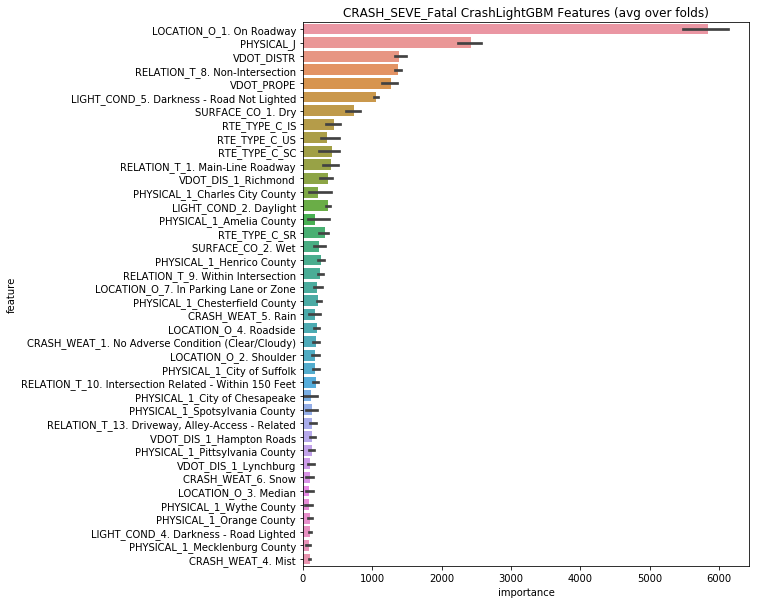

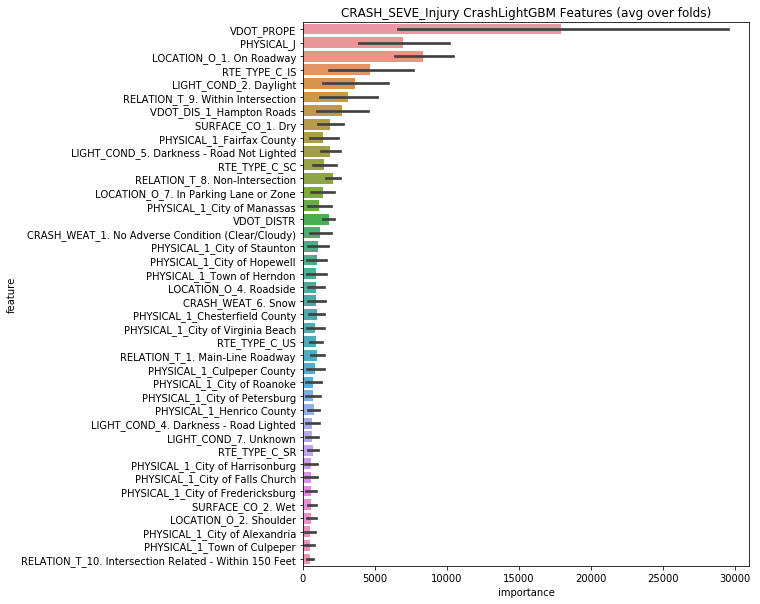

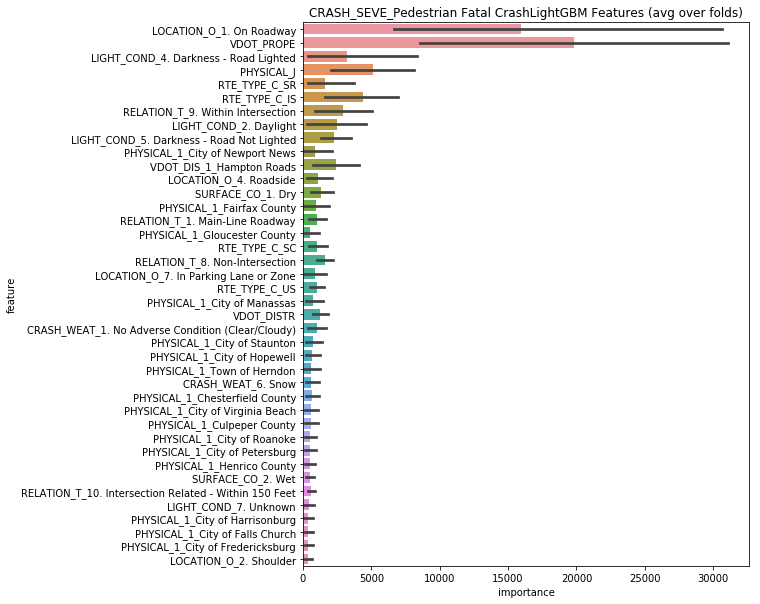

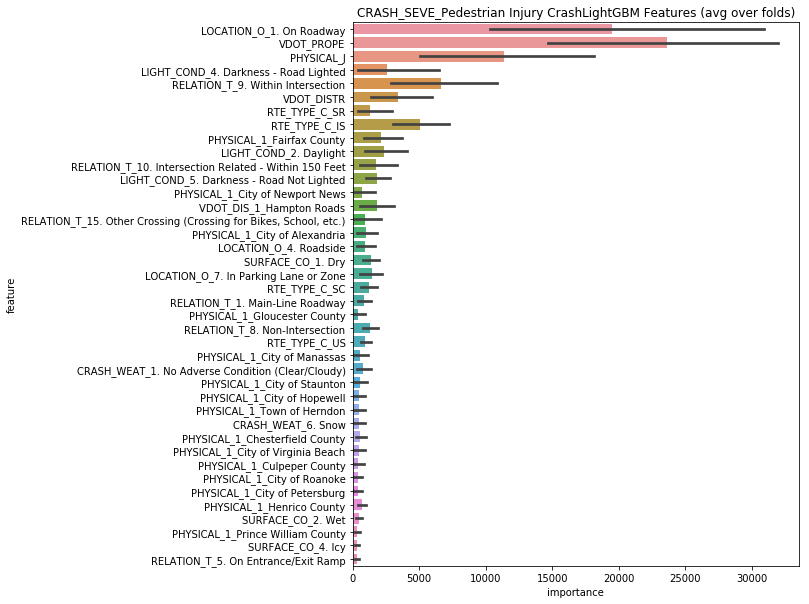

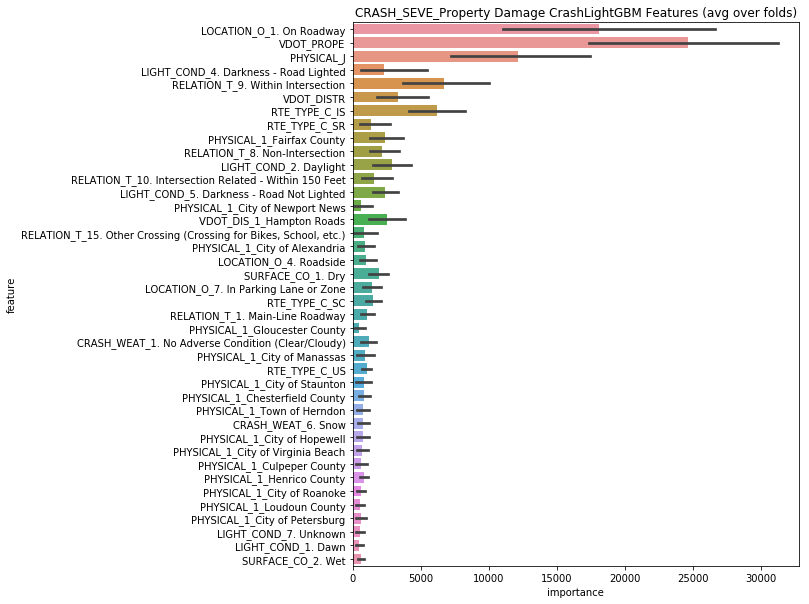

In [20]:
sub=kfold_lightgbm(train_df,test_df,3)

In [ ]:
df['CRASH_SEVE_Property Damage Crash'].head()